In [1]:
import os
import copy

from fair import FAIR
from fair.interface import fill, initialise
from fair.io import read_properties
import pandas as pd
import numpy as np
import matplotlib.pyplot as pl
from tqdm.auto import tqdm
from scipy.stats import linregress

In [2]:
f = FAIR()

In [3]:
f.define_time(1850, 2050, 1)

In [4]:
scenarios = ['esm-bell-750PgC', 'esm-bell-1000PgC', 'esm-bell-2000PgC']

In [5]:
# do one at a time
#scenarios = [scenarios[0]]
f.define_scenarios(scenarios)
fair_params_df = pd.read_csv('../data/fair2.1-parameters/calibration-1.4.0/calibrated_constrained_parameters.csv', index_col=0)

In [6]:
f.define_configs(list(fair_params_df.index))

In [7]:
species = ['CO2', 'CH4', 'N2O']
properties = {
    "CO2": {
        'type': 'co2',
        'input_mode': 'emissions',
        'greenhouse_gas': True,
        'aerosol_chemistry_from_emissions': False,
        'aerosol_chemistry_from_concentration': False
    },
    "CH4": {
        'type': 'ch4',
        'input_mode': 'emissions',
        'greenhouse_gas': True,
        'aerosol_chemistry_from_emissions': False,
        'aerosol_chemistry_from_concentration': False
    },
    "N2O": {
        'type': 'n2o',
        'input_mode': 'emissions',
        'greenhouse_gas': True,
        'aerosol_chemistry_from_emissions': False,
        'aerosol_chemistry_from_concentration': False
    }
}

In [8]:
# declare species and properties
f.define_species(species, properties)

In [9]:
f.allocate()

In [10]:
f.fill_from_rcmip()

In [11]:
f.concentration.loc[dict(specie='CH4')] = 808.2490285
f.concentration.loc[dict(specie='N2O')] = 273.021047

In [12]:
# Get default species configs
f.fill_species_configs()

# Climate response
fill(f.climate_configs['ocean_heat_capacity'], fair_params_df.loc[:,'clim_c1':'clim_c3'])
fill(f.climate_configs['ocean_heat_transfer'], fair_params_df.loc[:,'clim_kappa1':'clim_kappa3'])
fill(f.climate_configs['deep_ocean_efficacy'], fair_params_df.loc[:,'clim_epsilon'])
fill(f.climate_configs['gamma_autocorrelation'], fair_params_df.loc[:,'clim_gamma'])
fill(f.climate_configs['stochastic_run'], False)

# carbon cycle
fill(f.species_configs['iirf_0'], fair_params_df.loc[:, 'cc_r0'].values.squeeze(), specie='CO2')
fill(f.species_configs['iirf_airborne'], fair_params_df.loc[:, 'cc_rA'].values.squeeze(), specie='CO2')
fill(f.species_configs['iirf_uptake'], fair_params_df.loc[:, 'cc_rU'].values.squeeze(), specie='CO2')
fill(f.species_configs['iirf_temperature'], fair_params_df.loc[:, 'cc_rT'].values.squeeze(), specie='CO2')

# Scale CO2 forcing based on its 4xCO2 calibration
fill(f.species_configs["forcing_scale"], fair_params_df["fscale_CO2"].values.squeeze(), specie='CO2')

# initial condition of CO2 concentration (but not baseline for forcing calculations)
fill(f.species_configs['baseline_concentration'], 284.3169988, specie='CO2')
fill(f.species_configs['baseline_concentration'], 808.2490285, specie='CH4')
fill(f.species_configs['baseline_concentration'], 273.021047, specie='N2O')

In [13]:
fill(f.species_configs['forcing_reference_concentration'], 284.3169988, specie='CO2')
fill(f.species_configs['forcing_reference_concentration'], 808.2490285, specie='CH4')
fill(f.species_configs['forcing_reference_concentration'], 273.021047, specie='N2O')

In [14]:
f.species_configs

<xarray.Dataset>
Dimensions:                                   (config: 841, specie: 3, gasbox: 4)
Coordinates:
  * config                                    (config) int64 2463 ... 1597740
  * specie                                    (specie) <U3 'CO2' 'CH4' 'N2O'
  * gasbox                                    (gasbox) int64 0 1 2 3
Data variables: (12/31)
    tropospheric_adjustment                   (config, specie) float64 0.05 ....
    forcing_efficacy                          (config, specie) float64 1.0 .....
    forcing_temperature_feedback              (config, specie) float64 0.0 .....
    forcing_scale                             (config, specie) float64 1.006 ...
    partition_fraction                        (config, specie, gasbox) float64 ...
    unperturbed_lifetime                      (config, specie, gasbox) float64 ...
    ...                                        ...
    aci_shape                                 (config, specie) float64 0.0 .....
    cl_atoms                                  (specie) float64 0.0 0.0 0.0
    br_atoms                                  (specie) float64 0.0 0.0 0.0
    fractional_release                        (config, specie) float64 0.0 .....
    ch4_lifetime_chemical_sensitivity         (config, specie) float64 0.0 .....
    lifetime_temperature_sensitivity          (config) float64 -0.0408 ... -0...

In [15]:
# set initial conditions
initialise(f.concentration, f.species_configs['baseline_concentration'])
initialise(f.forcing, 0)
initialise(f.temperature, 0)
initialise(f.airborne_emissions, 0)
initialise(f.cumulative_emissions, 0)

In [16]:
f.run()

Running 2523 projections in parallel:   0%|          | 0/200 [00:00<?, ?timesteps/s]

In [17]:
f.forcing

<xarray.DataArray (timebounds: 201, scenario: 3, config: 841, specie: 3)>
array([[[[0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
         ...,
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00]],

        [[0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
         ...,
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00]],

        [[0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
         ...,
...
         ...,
         [1.88214035e+00, 0.00000000e+00, 0.00000000e+00],
         [1.59038625e+00, 0.00000000e+00, 0.00000000e+00],
         [1.81972426e+00, 0.00000000e+00, 0.00000000e+00]],

        [[2.56988720e+00, 0.00000000e+00, 0.00000000e+00],
         [2.75751512e+00, 0.00000000e+00, 0.00000000e+00],
         [2.41661470e+00, 0.00000000e+00, 0.00000000e+00],
         ...,
         [2.56050466e+00, 0.00000000e+00, 0.00000000e+00],
         [2.10071779e+00, 0.00000000e+00, 0.00000000e+00],
         [2.47759121e+00, 0.00000000e+00, 0.00000000e+00]],

        [[5.52755965e+00, 0.00000000e+00, 0.00000000e+00],
         [5.46825970e+00, 0.00000000e+00, 0.00000000e+00],
         [4.92986654e+00, 0.00000000e+00, 0.00000000e+00],
         ...,
         [5.20603660e+00, 0.00000000e+00, 0.00000000e+00],
         [4.08074512e+00, 0.00000000e+00, 0.00000000e+00],
         [5.12902294e+00, 0.00000000e+00, 0.00000000e+00]]]])
Coordinates:
  * timebounds  (timebounds) float64 1.85e+03 1.851e+03 ... 2.049e+03 2.05e+03
  * scenario    (scenario) <U16 'esm-bell-750PgC' ... 'esm-bell-2000PgC'
  * config      (config) int64 2463 2658 4204 4743 ... 1595003 1595963 1597740
  * specie      (specie) <U3 'CO2' 'CH4' 'N2O'

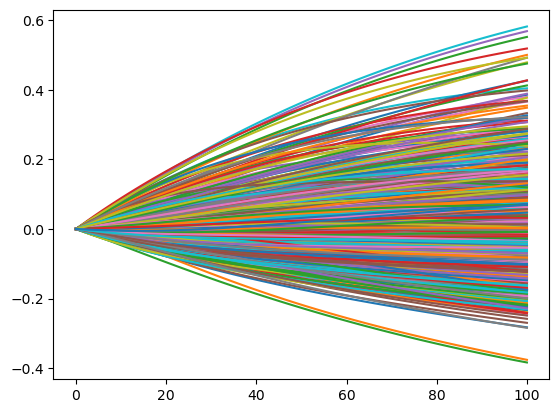

In [18]:
pl.plot(f.temperature[100:,0,:,0] - f.temperature[100,0,:,0]);

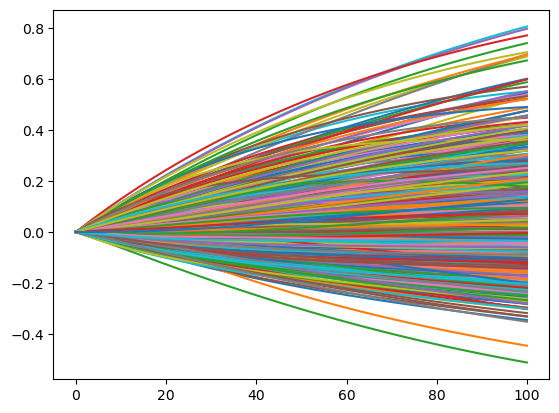

In [19]:
pl.plot(f.temperature[100:,1,:,0] - f.temperature[100,1,:,0]);

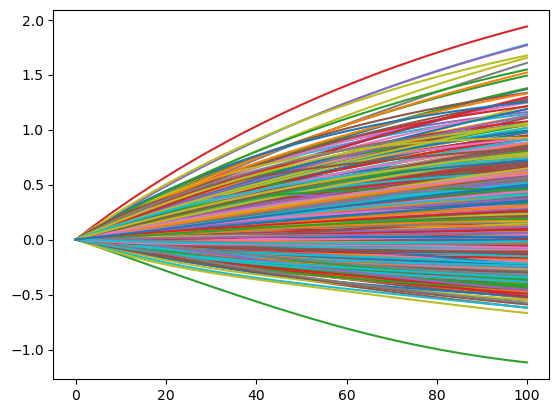

In [20]:
pl.plot(f.temperature[100:,2,:,0] - f.temperature[100,2,:,0]);

[-0.1197309  -0.01414555  0.1799758 ]
[-0.14718224 -0.00925841  0.24996061]
[-0.24686922  0.05863699  0.61392133]


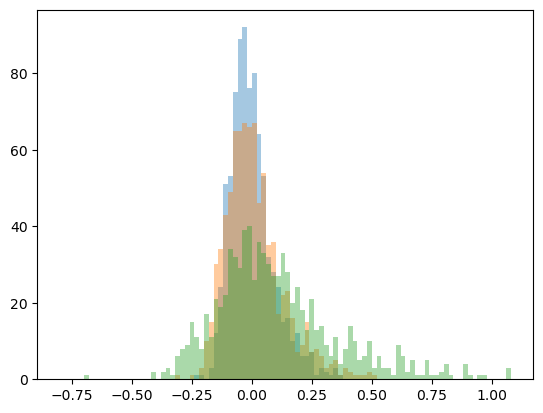

In [21]:
# ZEC50
pl.hist(f.temperature[150,0,:,0] - f.temperature[100,0,:,0], alpha=0.4, bins=np.arange(-0.8, 1.1, 0.02))
pl.hist(f.temperature[150,1,:,0] - f.temperature[100,1,:,0], alpha=0.4, bins=np.arange(-0.8, 1.1, 0.02))
pl.hist(f.temperature[150,2,:,0] - f.temperature[100,2,:,0], alpha=0.4, bins=np.arange(-0.8, 1.1, 0.02))
print(np.percentile(f.temperature[150,0,:,0] - f.temperature[100,0,:,0], (5,50,95)))
print(np.percentile(f.temperature[150,1,:,0] - f.temperature[100,1,:,0], (5,50,95)))
print(np.percentile(f.temperature[150,2,:,0] - f.temperature[100,2,:,0], (5,50,95)))

[-0.1911643  -0.01832832  0.27437642]
[-2.33286938e-01 -3.39388709e-04  3.96654309e-01]
[-0.37854918  0.1004804   0.9732575 ]


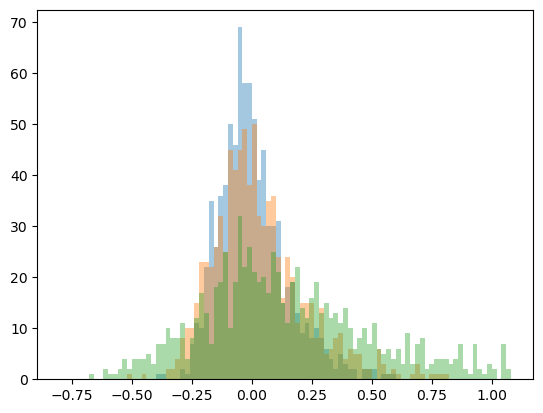

In [22]:
# ZEC100
pl.hist(f.temperature[200,0,:,0] - f.temperature[100,0,:,0], alpha=0.4, bins=np.arange(-0.8, 1.1, 0.02))
pl.hist(f.temperature[200,1,:,0] - f.temperature[100,1,:,0], alpha=0.4, bins=np.arange(-0.8, 1.1, 0.02))
pl.hist(f.temperature[200,2,:,0] - f.temperature[100,2,:,0], alpha=0.4, bins=np.arange(-0.8, 1.1, 0.02))
print(np.percentile(f.temperature[200,0,:,0] - f.temperature[100,0,:,0], (5,50,95)))
print(np.percentile(f.temperature[200,1,:,0] - f.temperature[100,1,:,0], (5,50,95)))
print(np.percentile(f.temperature[200,2,:,0] - f.temperature[100,2,:,0], (5,50,95)))

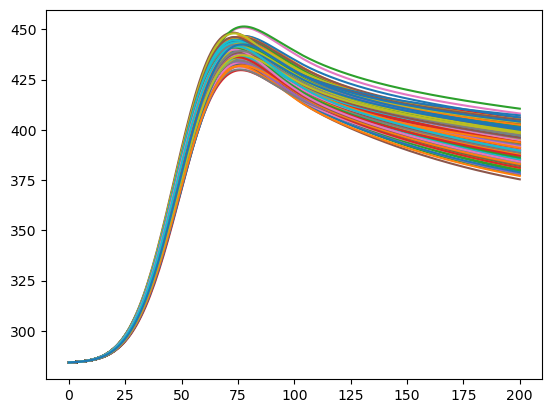

In [23]:
pl.plot(f.concentration[:,0,:,0]);

In [24]:
f.temperature[150,0,12,0] - f.temperature[100,0,12,0]

<xarray.DataArray ()>
array(-0.04996363)
Coordinates:
    scenario  <U16 'esm-bell-750PgC'
    config    int64 20262
    layer     int64 0

In [25]:
f.temperature[150,0,:,0] - f.temperature[100,0,:,0]

<xarray.DataArray (config: 841)>
array([-4.32405285e-02, -1.09444019e-01,  3.95362430e-02,  1.55749992e-01,
       -1.03749447e-02, -7.31615383e-02, -9.71148403e-02,  1.27455009e-01,
       -1.10163806e-01,  1.24806809e-01,  1.29356673e-01,  5.22197662e-02,
       -4.99636296e-02,  2.34781651e-02, -6.60671028e-04, -2.74422243e-02,
        3.70833704e-02, -8.10957332e-02,  5.60994944e-02, -8.92428812e-02,
        7.51050226e-02,  8.73795890e-02, -6.01656625e-03, -1.50388245e-01,
        1.09812280e-01, -1.53501459e-01, -1.97371962e-03,  8.41587932e-02,
        9.31129803e-02,  3.95582522e-03,  1.87687060e-01, -8.49137829e-02,
       -9.05724733e-02, -2.46346425e-02, -7.85536445e-02, -1.10409656e-01,
       -1.05766347e-01, -3.21719111e-02,  1.65360857e-01, -3.32419580e-02,
       -9.29770378e-02, -7.26639167e-04,  5.74895047e-02, -3.61769339e-02,
       -1.47114572e-02, -2.16884571e-02,  1.03289791e-02, -4.96296899e-03,
       -2.70361202e-02, -9.70547889e-02, -2.06656928e-02,  4.16438240e-02,
        3.61615800e-02, -1.02335726e-01, -8.42197275e-02, -7.51550879e-02,
       -2.58914368e-02,  3.88149049e-02,  1.00002303e-02,  2.91540312e-01,
        8.75448910e-03,  2.63797115e-02, -4.26074223e-02,  8.48484807e-02,
        2.05758281e-01, -6.95636344e-02,  7.44043159e-02, -6.60387715e-02,
       -6.98885550e-02,  3.62779924e-01, -4.70867105e-02,  9.99173639e-03,
       -4.80011882e-02, -1.73729143e-02,  1.05388015e-01,  1.53936013e-01,
       -1.18466852e-01,  2.81515315e-02,  2.03875551e-02, -3.21754059e-02,
...
        1.79167714e-01,  3.77267491e-03,  1.97452061e-02,  9.74714842e-02,
        1.57383956e-01, -7.26503896e-02, -3.03103495e-02, -5.77238322e-02,
       -1.28843390e-01, -1.09910744e-01, -2.18789112e-02, -1.51329599e-01,
        9.05671290e-03, -3.10211340e-02, -3.89073107e-02, -3.88293746e-02,
        2.52270688e-01, -5.82214740e-02,  3.03841253e-01, -7.17277243e-02,
        5.78332665e-03, -3.45948232e-03,  2.97608737e-02,  1.11623977e-01,
        3.30225156e-01, -1.16658736e-01, -1.56775628e-02,  4.49292168e-02,
       -2.12479120e-02, -4.79788831e-02, -1.72134259e-02,  1.32019393e-01,
       -1.54514325e-02,  2.39021746e-01,  8.33361932e-02, -2.72232886e-02,
        1.41476750e-02,  5.94788024e-02,  1.42305290e-01, -1.33792738e-02,
        9.33966791e-03,  1.71825112e-02, -4.80107406e-02, -1.58090308e-02,
        2.03881826e-01,  3.62094307e-02, -7.33713702e-02, -1.84661199e-02,
       -1.87025304e-02, -8.06952957e-02, -1.18912756e-01, -8.93719789e-02,
        1.03378687e-01, -1.13840328e-01,  1.58906541e-02, -1.10159522e-01,
       -6.48375158e-02,  2.41105156e-03,  2.81240059e-03, -2.33236116e-02,
        5.46234028e-02,  1.65393970e-01,  4.84030096e-02, -1.62834195e-01,
       -5.25378179e-02,  1.35098543e-01,  3.17649218e-02,  4.47437489e-02,
        4.95353427e-02,  2.41351183e-02, -5.05573510e-02, -8.49584085e-02,
       -2.03057176e-02, -6.38108062e-02,  1.39818852e-01, -2.92876680e-02,
        1.91078377e-02])
Coordinates:
    scenario  <U16 'esm-bell-750PgC'
  * config    (config) int64 2463 2658 4204 4743 ... 1595003 1595963 1597740
    layer     int64 0

In [26]:
df = pd.DataFrame(
    np.array([
        f.temperature[148,0,:,0] - f.temperature[100,0,:,0], 
        f.temperature[150,0,:,0] - f.temperature[100,0,:,0], 
        f.temperature[200,0,:,0] - f.temperature[100,0,:,0],
        f.temperature[150,1,:,0] - f.temperature[100,1,:,0], 
        f.temperature[200,1,:,0] - f.temperature[100,1,:,0],
    ]).T,
    index=fair_params_df.index, 
    columns=['zec48_750', 'zec50_750', 'zec100_750', 'zec50_1000', 'zec100_1000']
)

In [27]:
os.makedirs('../results/', exist_ok=True)
df.to_csv('../results/zec_esm-bell_cal-1.4.0.csv')